# Introduction to PyTorch modules

Implementing neural network models from scratch, as we did in the last notebook, does not scale up to larger models or more complex problems. To facilitate and streamline the creation of neural network models, PyTorch uses modules. These are classes that inherit from the base `torch.nn.Module` class. All modules, including layers, which are, as we will see, the building blocks of deep neural networks, inherit from this base class.

Let's examine some of the different roles these modules play in PyTorch, starting with the necessary imports.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## Simple linear regression
Fist, let's build a simple linear regression model using the linear module (layer).  

### Preparing the data
Here is the data we'll be working with:

In [2]:
X = torch.rand(200).reshape(-1, 1)
y = 3 * X + .3 * torch.randn(len(X),1)

Let's shuffle it:

In [3]:
indexes = torch.randperm(len(X))
X = X[indexes]
y = y[indexes]

And split it into two sets:

In [4]:
split_at = int(.8 * len(X))
X_train, X_test = X[0:split_at], X[split_at:]
y_train, y_test = y[0:split_at], y[split_at:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([160, 1]),
 torch.Size([160, 1]),
 torch.Size([40, 1]),
 torch.Size([40, 1]))

Let's see how it looks:

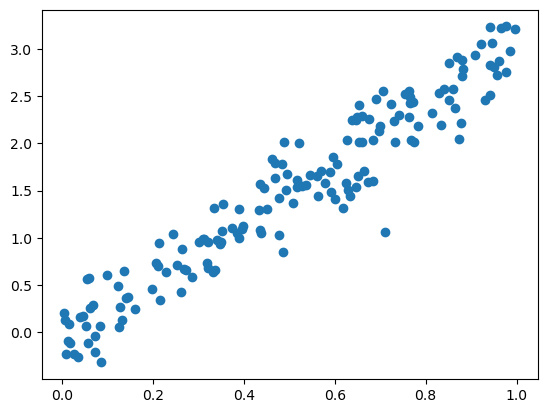

In [5]:
plt.plot(X_train, y_train, 'o')

### Using the linear module (layer)

We can use a linear layer (module) to fit a simple line to this data. This layer is implemented by the `torch.nn.Linear` class. Let's create a model based on this layer.

In [6]:
model = nn.Linear(1, 1)

The `(1,1)` arguments indicate a 1D input  and a 1D output. This layer will already come with its parameters (bias and weight) initialized. We can print these parameters:

In [7]:
model.bias, model.weight

(Parameter containing:
 tensor([0.9278], requires_grad=True),
 Parameter containing:
 tensor([[0.3624]], requires_grad=True))

or:

In [8]:
list(model.parameters())

[Parameter containing:
 tensor([[0.3624]], requires_grad=True),
 Parameter containing:
 tensor([0.9278], requires_grad=True)]

or even:

In [9]:
model.state_dict()

OrderedDict([('weight', tensor([[0.3624]])), ('bias', tensor([0.9278]))])

To train this model, we can create our own loss function and call the backward method on it, as we did in the previous notebook. Instead, PyTorch gives us access to different loss functions and optimizers. Let's use them. We'll utilize the `torch.nn.MSELoss()` (Mean Squared Error) loss and the `torch.optim.SGD` (Stochastic Gradient Descent) optimizer.

In [10]:
loss_fn = nn.MSELoss()
optimizer =  torch.optim.SGD(model.parameters(), lr = 0.03) 

Having done that, our training loop simplifies to the following:

In [11]:
epochs = 500
losses = []
lr = .01
for i in range(1, epochs + 1):
    # 1
    y_hat = model(X_train)
    loss = loss_fn(y_train, y_hat)

    # 2
    optimizer.zero_grad()
    
    #3
    loss.backward()

    #4
    optimizer.step()

    #5
    losses.append(loss.item())
    if i == 1 or i % 100 == 0:
        print(f"Epoch {i: 4d}: loss ={loss.item(): .4f}")

Epoch    1: loss = 0.8230
Epoch  100: loss = 0.3160
Epoch  200: loss = 0.1817
Epoch  300: loss = 0.1203
Epoch  400: loss = 0.0922
Epoch  500: loss = 0.0794


As you can see, the first step is to call the model and use its output to calculate the loss. Then `optimizer.zero_grad()` is called. This step is IMPORTANT! It resets the gradients of the trainable parameters to 0. By design, Autograd accumulates gradients, and we need this call to reset gradients at the beginning of every training step/iteration.

The `optimizer.step()` updates the trainable parameters (bias and weights) based on the gradients of the loss function calculated by the `loss.backward()` call.

These are labeled in the code above as numbers 1, 2, 3, and 4. They are the basis steps that every training step/iteration must have. Other steps, such as step 5 above, can be added, but they are optional.

Finally, we'll create a function to plot the results and call it.

torch.float32
tensor([[0.0240],
        [2.9120]], grad_fn=<AddmmBackward0>)


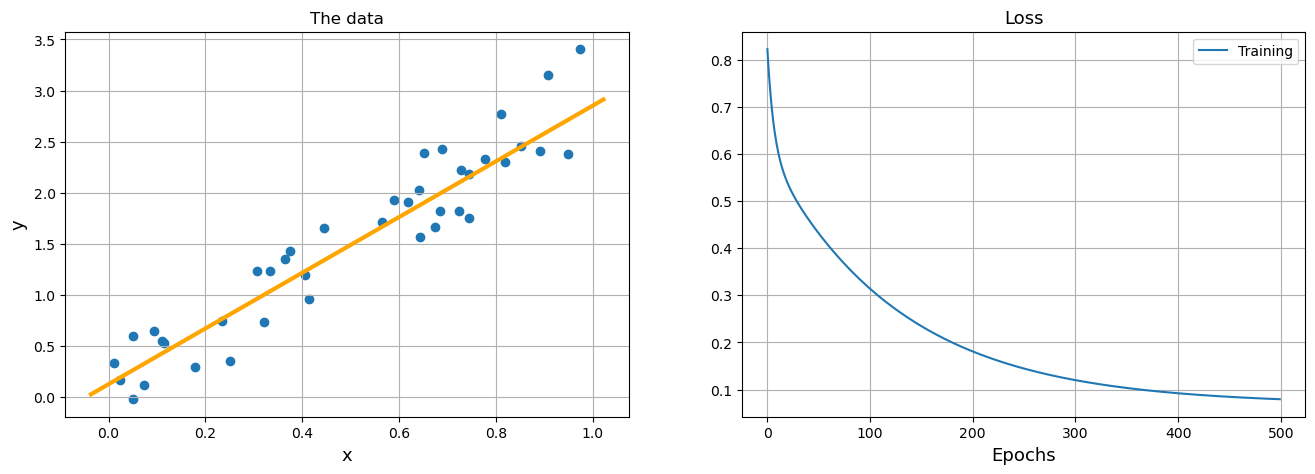

In [12]:
def plotLinearRegressorResults(X, y, model, losses):
    fig = plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(X, y, marker='o')
    x1, x2 = plt.xlim()

    input = torch.tensor([[x1], [x2]], dtype=torch.float)# - mean)/std
    print(input.dtype)
    output = model(input) 
    print(output)
    plt.plot((x1, x2), output.detach(), color="orange", linewidth=3)
    plt.xlabel('x', size=13)
    plt.ylabel('y', size=13)
    plt.title('The data')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(losses, label = "Training")
    # plt.plot(hist['val_loss'], label = "Validation")
    plt.title('Loss', size=13)
    plt.xlabel('Epochs', size=13)
    plt.grid()
    plt.legend()

    plt.show()
    
plotLinearRegressorResults(X_test, y_test, model, losses)

And we can even plot the computational graph of this model.

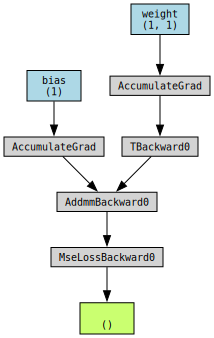

In [13]:
from torchviz import make_dot
make_dot(loss, params=dict(model.named_parameters()))

### Using the Sequential model

PyTorch provides multiple ways to achieve the same goal. For straightforward deep neural networks (DNNs), the **Sequential module** is all you need. This module allows the creation of neural networks using a sequence of modules (layers), one feeding into the next like in a pipeline. Here is a simple sequential module with a single linear layer.

In [14]:
model = nn.Sequential(nn.Linear(1,1))

We can print a tabular summary of this module using `torchinfo.summary()` function.

In [15]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            2
Total params: 2
Trainable params: 2
Non-trainable params: 0

Some models may have both trainable and non-trainable parameters. Notice a few things here:
* We have two trainable parameters: one for the bias (intercept) of the regression line and one for its weight (slope).
* Both of these parameters will be learned from the data when we train this model. That is why these parameters are called trainable.

Here are the parameters of the whole model (with all the layers):

In [16]:
model.state_dict(), list(model.parameters())

(OrderedDict([('0.weight', tensor([[0.6151]])),
              ('0.bias', tensor([-0.5811]))]),
 [Parameter containing:
  tensor([[0.6151]], requires_grad=True),
  Parameter containing:
  tensor([-0.5811], requires_grad=True)])

And using indexing, you can access the parameters of an individual layer. Here are the bias and weight parameters of the first layer in the sequence.

In [17]:
model[0].bias, model[0].weight

(Parameter containing:
 tensor([-0.5811], requires_grad=True),
 Parameter containing:
 tensor([[0.6151]], requires_grad=True))

If you want to label every layer, pass an `OrderedDict` object to the sequential module like this:

In [18]:
from collections import OrderedDict

model = nn.Sequential(OrderedDict([
    ('linear', nn.Linear(1, 1))
]))

summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            2
Total params: 2
Trainable params: 2
Non-trainable params: 0

Before we train this model, we need to configure it, as we did above, by specifying the following:
* What optimizer to use. There are many gradient-based optimizers to choose from. You can see the list of supported optimizers [at this page](https://pytorch.org/docs/stable/optim.html#algorithms).
* What loss function to use. A list of the supported losses is available [at this page](https://pytorch.org/docs/stable/nn.html#loss-functions). This is a regression problem, so we will be using the `torch.nn.MSELoss` loss.

In [19]:
loss_fn = nn.MSELoss()
optimizer =  torch.optim.SGD(model.parameters(), lr = 0.03) 

In [20]:
epochs = 500
losses = []
lr = .01
for i in range(1, epochs + 1):
    y_hat = model(X_train)
    loss = loss_fn(y_train, y_hat)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
      
    losses.append(loss.item())
    if i == 1 or i % 100 == 0:
        print(f"Epoch {i: 4d}: loss ={loss.item(): .4f}")

Epoch    1: loss = 1.6575
Epoch  100: loss = 0.1679
Epoch  200: loss = 0.1140
Epoch  300: loss = 0.0893
Epoch  400: loss = 0.0781
Epoch  500: loss = 0.0729


To plot the results, we'll create a fucntion then call it.

torch.float32
tensor([[-0.0513],
        [ 2.9753]], grad_fn=<AddmmBackward0>)


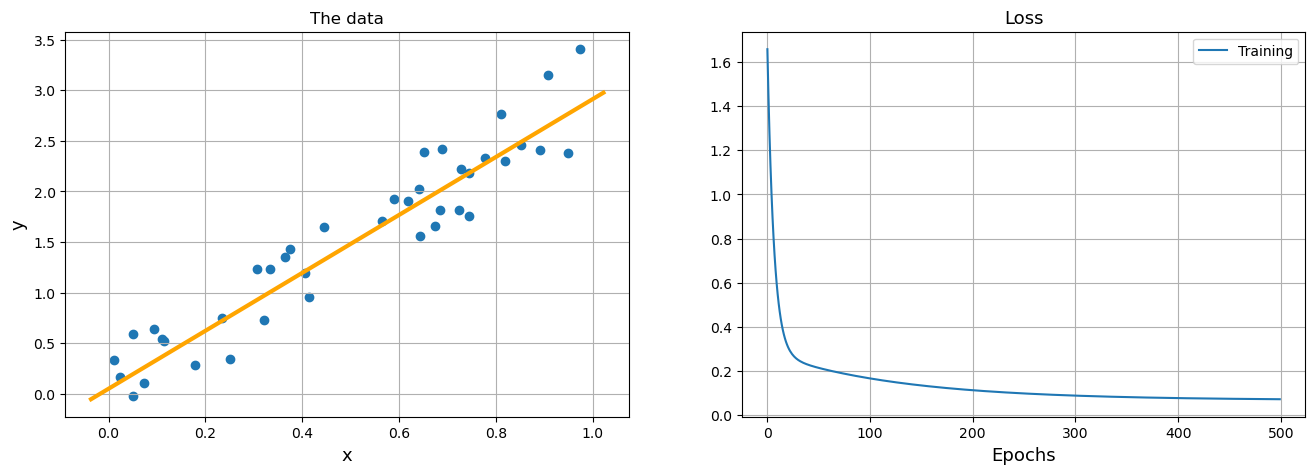

In [21]:
plotLinearRegressorResults(X_test, y_test, model, losses)

Here is a plot of the model.

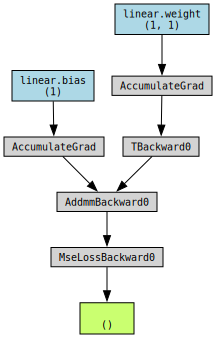

In [22]:
from torchviz import make_dot
make_dot(loss, params=dict(model.named_parameters()))

Finally we can make predictions by calling the model as if it is a function like this:

In [23]:
predictions = model(X_test[:10])
predictions

tensor([[2.0086],
        [2.2757],
        [2.4890],
        [1.0061],
        [0.0863],
        [2.3680],
        [1.8834],
        [0.1968],
        [1.7388],
        [0.3817]], grad_fn=<AddmmBackward0>)

### Using `nn.Module`

For more flexibility and control, the `nn.Module` could be subclassed. This gives us, as will be seen in subsequent notebooks, the ability to create deep and complex networks. For now and as a simple example, we'll create a class that implements simple linear regression using the data above.

This class simply inherits from `torch.nn.Module` and has two methods:
* A constructor to receive outside arguments (and/or hyperparameters) and set things up.
* The forward method, which receives input data, runs a forward pass through the network, and returns the final output, one for each input example.

Here is what this class looks like:"

In [24]:
class LinearRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.w = nn.Parameter(torch.randn(1, requires_grad=True))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True))

    def forward(self, x):
        return self.w * x + self.b

We could have used the `nn.Linear()` layer inside this class. Instead, this class shows how layers like `nn.Linear()` creates their own parameters.

Let's instantiate this model, print its parameters, and summarize it.

In [25]:
model = LinearRegressor()
model.state_dict(), summary(model)

(OrderedDict([('w', tensor([3.1895])), ('b', tensor([-1.6470]))]),
 Layer (type:depth-idx)                   Param #
 LinearRegressor                          2
 Total params: 2
 Trainable params: 2
 Non-trainable params: 0
 =================================================================)

And like before, we'll specify the loss and the optimizer and then train it.

In [26]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.03) 

In [27]:
epochs = 1000
losses = []
for i in range(1, epochs + 1):
    y_hat = model(X_train)
    loss = loss_fn(y_train, y_hat)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if i == 1 or i % 100 == 0:
        print(f"Epoch {i: 4d}: loss ={loss.item(): .4f}")

Epoch    1: loss = 2.3969
Epoch  100: loss = 0.0896
Epoch  200: loss = 0.0782
Epoch  300: loss = 0.0730
Epoch  400: loss = 0.0706
Epoch  500: loss = 0.0695
Epoch  600: loss = 0.0690
Epoch  700: loss = 0.0688
Epoch  800: loss = 0.0687
Epoch  900: loss = 0.0686
Epoch  1000: loss = 0.0686


Let's plot its results and curves:

torch.float32
tensor([[-0.1899],
        [ 3.0919]], grad_fn=<AddBackward0>)


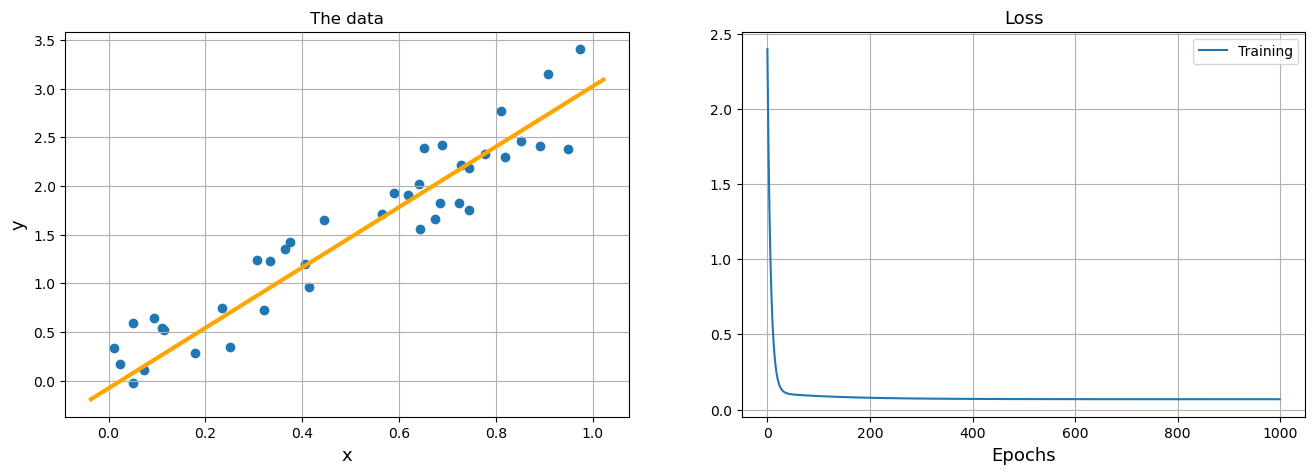

In [28]:
plotLinearRegressorResults(X_test, y_test, model, losses)

## Logistic regression
The model above has one layer and not activation function. If we add a sigmoid activation function to it, we get a model commonly called `logistic regression` which despite the name is used for classification. The sigmoid function is defined as:

$$ \sigma(z) = \frac{1}{1 + e^{-z}}$$

Before we implement this model, let's generate some sample data:

(torch.Size([500, 2]), torch.Size([500, 1]))

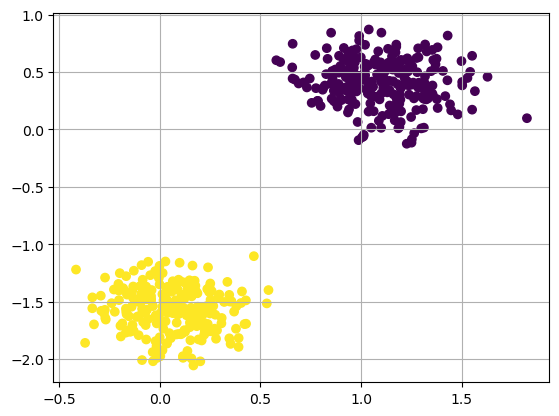

In [29]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=500, centers=2)

X = (X - X.mean()) / X.std()

X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float().reshape(-1, 1)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.grid()

X.shape, y.shape

The data has 2 input features and one single output value. Using the sequential module, we could write:

In [30]:
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            3
├─Sigmoid: 1-2                           --
Total params: 3
Trainable params: 3
Non-trainable params: 0

Because this is a binary classification model, the loss function will be different. We'll use `torch.nn.BCELoss` (Binary Cross Entropy Loss).

In [31]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01) 

We can not train it:

In [32]:
epochs = 500
losses = []
for i in range(1, epochs + 1):    
    y_hat = model(X)
    loss = loss_fn(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    losses.append(loss.item())
    if i == 1 or i % 100 == 0:
        print(f"Epoch {i: 4d}: loss ={loss.item(): .4f}")

Epoch    1: loss = 0.8645
Epoch  100: loss = 0.5616
Epoch  200: loss = 0.3954
Epoch  300: loss = 0.2983
Epoch  400: loss = 0.2369
Epoch  500: loss = 0.1953


Let's plot its results and curves:

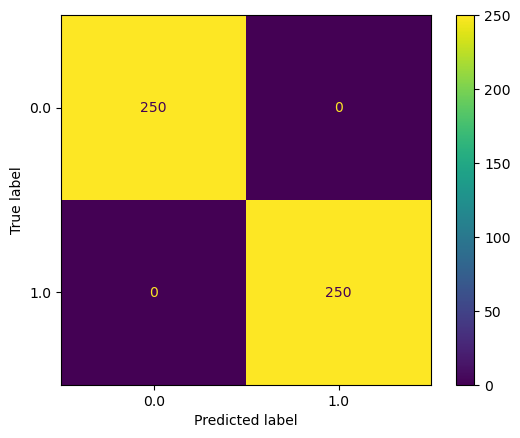

In [33]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

accuracy_score(y, torch.where(model(X).detach() > .5, 1 , 0))
ConfusionMatrixDisplay.from_predictions(y, torch.where(model(X).detach() > .5, 1 , 0))

In [34]:
def plot_decision_regions(X, y, learner, resolution=0.01, title="Decision regions", ax=None):    
    if ax is None:
        fig = plt.figure(figsize=(16,9))
        ax = fig.add_subplot(1,1,1)
        
    # Plot the decision boundary.
    x_min, x_max = torch.min(X[:,0]) - 1, torch.max(X[:,0]) + 1
    y_min, y_max = torch.min(X[:,1]) - 1, torch.max(X[:,1]) + 1
    xx, yy = torch.meshgrid(torch.arange(x_min, x_max, resolution),
                         torch.arange(y_min, y_max, resolution), indexing="ij")
    # print(torch.stack((xx.ravel(), yy.ravel())).T)
    Z = learner(torch.stack((xx.ravel(), yy.ravel())).T).detach()
    Z = torch.where(Z > .5, 1, 0)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.rcParams['pcolor.shading'] ='nearest'
    ax.pcolormesh(xx.numpy(), yy.numpy(), Z.numpy(), cmap=plt.cm.Paired, alpha=.75)

    # Plot the points
    ax.scatter(
        x=X[:, 0],
        y=X[:, 1], c=y, cmap=plt.cm.Paired,
        edgecolor='k', s=60)
    
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    # plt.legend(loc='best')
    ax.set_title(title)

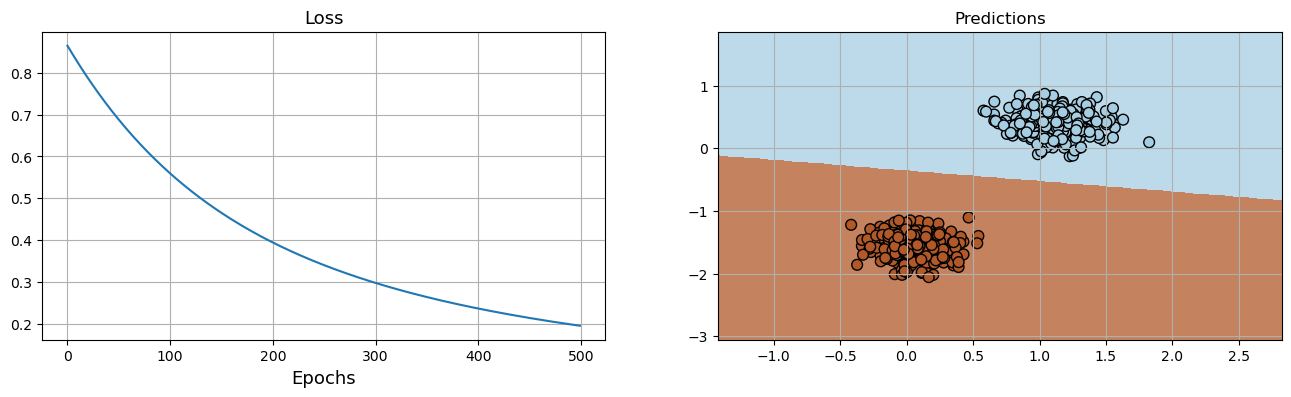

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

ax[0].plot(losses)
ax[0].set_title('Loss', size=13)
ax[0].set_xlabel('Epochs', size=13)
ax[0].grid()


pp = torch.where(model(X).detach() > .5, 1 , 0)
plot_decision_regions(X, pp, model, ax=ax[1])

ax[1].set_title('Predictions')
ax[1].grid()

plt.show()

## Multi-layer Perceptron

In this section we'll implement a simple MLP with multiple hidden layers and one output layer. But first, let's start with the data:

In [36]:
n = 100

means = torch.tensor([[1., 5.], [7., 8.], [10., 2.]])
cov_mats = torch.tensor([
    [[1.5, .6], [.6, 1]], [[2, 0.8], [0.8, 2]], [[2.5, 0.7], [0.7, 2.5]]
])
data = []
for i in range(3):
    data.append(torch.distributions.MultivariateNormal(means[i], cov_mats[i]).sample((n,)))

X = torch.concat(data, axis=0)

y = torch.concat((torch.zeros(n), torch.ones(n), torch.full((n,), 2.)), axis=0).long()

X.shape, y.shape

(torch.Size([300, 2]), torch.Size([300]))

Let's shuffle the data:

In [37]:
shuffled_indices = torch.randperm(3 * n)
X, y = X[shuffled_indices], y[shuffled_indices]
X.shape, y.shape

(torch.Size([300, 2]), torch.Size([300]))

Let's split it into three sets: training, validation, and test.

In [38]:
X_train, y_train = X[:200,:], y[:200] 
X_val, y_val = X[200:250,:], y[200:250] 
X_test, y_test = X[-50:,:], y[-50:] 

We can normalize the data here using means and standard deviations calculated using the training data. Or we can use normalization pre-processing layer of Keras. We'll do the latter.

Let's plot the training data:

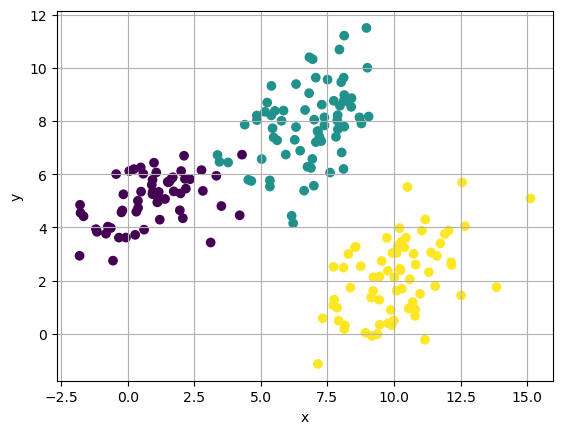

In [39]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Let's standardize the data:

In [40]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train, X_val, X_test = (X_train - mean)/std, (X_val - mean)/std, (X_test - mean)/std

We'll start by using a sequential model with 4 hidden linear layers each with 8 units and a ReLU activation functions. We might not need all of these layers, but this gives us an example of a "deep-ish" network. The last layer is linear with three output "logit" values.

In [41]:
mlp = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 8),
    nn.ReLU(),
    nn.Linear(8, 8),
    nn.ReLU(),
    nn.Linear(8, 8),
    nn.ReLU(),
    nn.Linear(8, 3)
)

summary(mlp)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            24
├─ReLU: 1-2                              --
├─Linear: 1-3                            72
├─ReLU: 1-4                              --
├─Linear: 1-5                            72
├─ReLU: 1-6                              --
├─Linear: 1-7                            72
├─ReLU: 1-8                              --
├─Linear: 1-9                            27
Total params: 267
Trainable params: 267
Non-trainable params: 0

Let's plot this model:

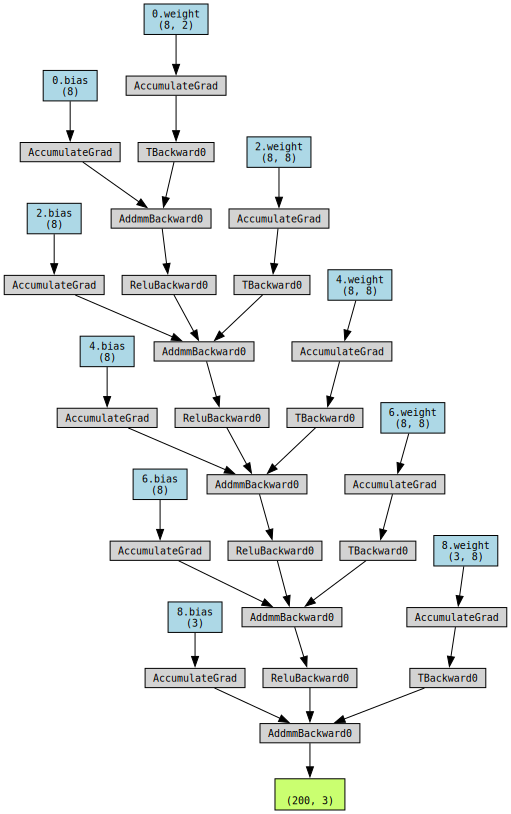

In [42]:
make_dot(mlp(X_train), params=dict(mlp.named_parameters()))

Because this is a multiclass classifier, and the output layer has 3 units (one for every class), the loss function will be `torch.nn.CrossEntropyLoss()`. Let's also use a different optimizer: RMSprop for a change."

In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(mlp.parameters()) 

In [44]:
epochs = 100
losses = []
for i in range(1, epochs + 1):
    y_hat = mlp(X_train)
    loss = loss_fn(y_hat, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    losses.append(loss.item())
    if i == 1 or i % 10 == 0:
        print(f"Epoch {i: 4d}: loss ={loss.item(): .4f}")

Epoch    1: loss = 1.1018
Epoch   10: loss = 0.5915
Epoch   20: loss = 0.1986
Epoch   30: loss = 0.1144
Epoch   40: loss = 0.0653
Epoch   50: loss = 0.0411
Epoch   60: loss = 0.0319
Epoch   70: loss = 0.0265
Epoch   80: loss = 0.0253
Epoch   90: loss = 0.0229
Epoch  100: loss = 0.0214


Finally let's plot the decision regions.

torch.Size([291591]) torch.Size([537, 543])


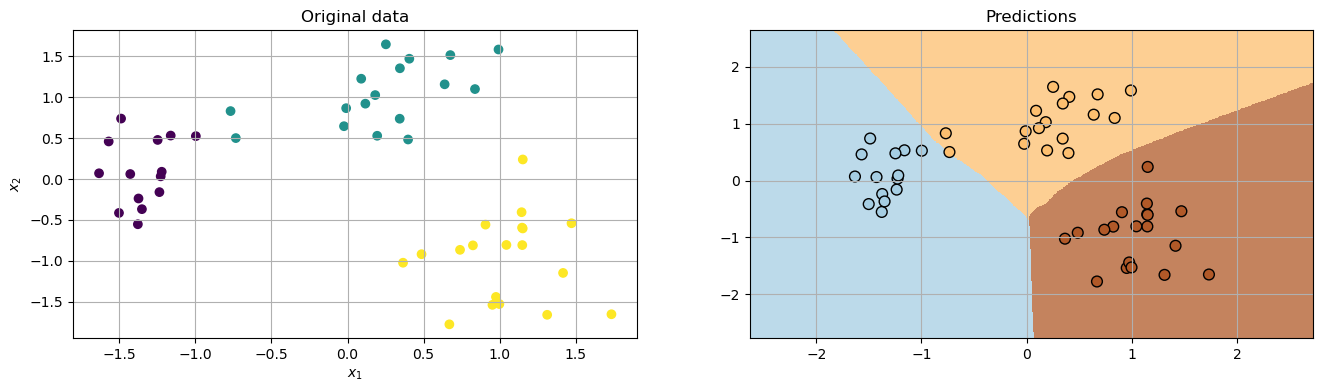

In [45]:
def plot_decision_regions(X, y, learner, resolution=0.01, title="Decision regions", ax=None):    
    if ax is None:
        fig = plt.figure(figsize=(16,9))
        ax = fig.add_subplot(1,1,1)
        
    # Plot the decision boundary.
    x_min, x_max = torch.min(X[:,0]) - 1, torch.max(X[:,0]) + 1
    y_min, y_max = torch.min(X[:,1]) - 1, torch.max(X[:,1]) + 1
    xx, yy = torch.meshgrid(torch.arange(x_min, x_max, resolution),
                         torch.arange(y_min, y_max, resolution), indexing="ij")
    # print(torch.stack((xx.ravel(), yy.ravel())).T)
    Z = learner(torch.stack((xx.ravel(), yy.ravel())).T).detach()
    Z = np.argmax(Z, axis=1)
    print(Z.shape, xx.shape)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.rcParams['pcolor.shading'] ='nearest'
    ax.pcolormesh(xx.numpy(), yy.numpy(), Z.numpy(), cmap=plt.cm.Paired, alpha=.75)

    # Plot the points
    ax.scatter(
        x=X[:, 0],
        y=X[:, 1], c=y, cmap=plt.cm.Paired,
        edgecolor='k', s=60)
    
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    # plt.legend(loc='best')
    ax.set_title(title)
    
fig, ax = plt.subplots(1, 2, figsize=(16,4))

ax[0].scatter(X_test[:, 0], X_test[:, 1], c=y_test)
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
ax[0].set_title('Original data')
ax[0].grid()

pp = np.argmax(mlp(X_test).detach(), axis=1)
plot_decision_regions(X_test, pp, mlp, ax=ax[1])

ax[1].set_title('Predictions')
ax[1].grid()

plt.show()

## Saving and reloading modules

Trained models can be saved to a file for future use. Here is how we can save the above model:

In [46]:
path = 'mlp_v0.1.pth'
torch.save(mlp, path)

The `save(mlp)` call above will save both the model architecture and all of its trained parameters. Having done that, we can reload the saved the model like this:
Now, let’s reload the saved model. Since we have saved both the model architecture and the weights, we can easily rebuild and reload the parameters in just one line:

In [47]:
mlp_from_saved = torch.load(path)
mlp_from_saved

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=8, bias=True)
  (5): ReLU()
  (6): Linear(in_features=8, out_features=8, bias=True)
  (7): ReLU()
  (8): Linear(in_features=8, out_features=3, bias=True)
)

Let's evaluate it and plot its results:

torch.Size([291591]) torch.Size([537, 543])


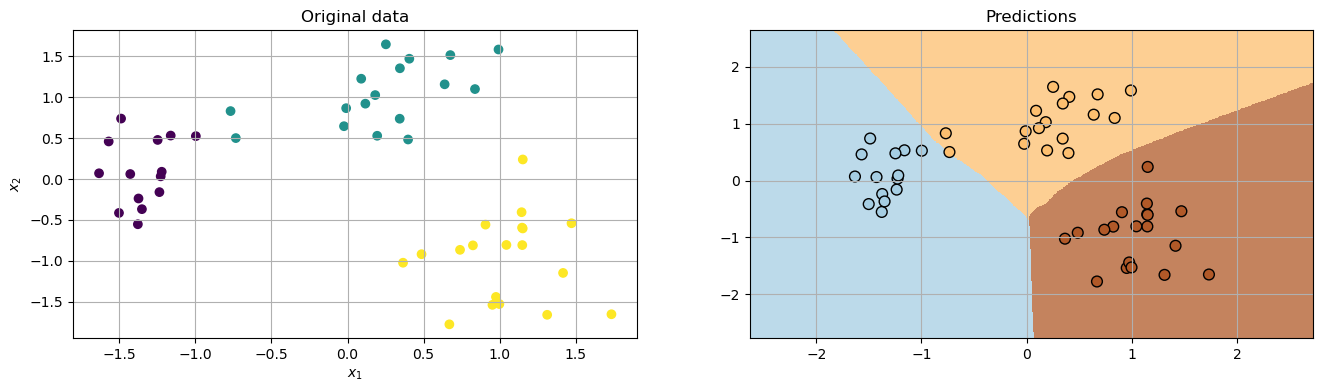

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

ax[0].scatter(X_test[:, 0], X_test[:, 1], c=y_test)
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
ax[0].set_title('Original data')
ax[0].grid()

pp = np.argmax(mlp_from_saved(X_test).detach(), axis=1)
plot_decision_regions(X_test, pp, mlp_from_saved, ax=ax[1])

ax[1].set_title('Predictions')
ax[1].grid()

plt.show()

Alternatively, we could save the trained parameters by themselves. Here is how to do so:

In [49]:
path = 'mlp_state_v0.1.pth'
torch.save(mlp.state_dict(), path)

To reload the saved parameters, we first need to create the model then feed the loaded parameters to it:

In [50]:
new_mlp = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 8),
    nn.ReLU(),
    nn.Linear(8, 8),
    nn.ReLU(),
    nn.Linear(8, 8),
    nn.ReLU(),
    nn.Linear(8, 3)
)
new_mlp.load_state_dict(torch.load(path))

<All keys matched successfully>

Let's evaluate this new model:

torch.Size([291591]) torch.Size([537, 543])


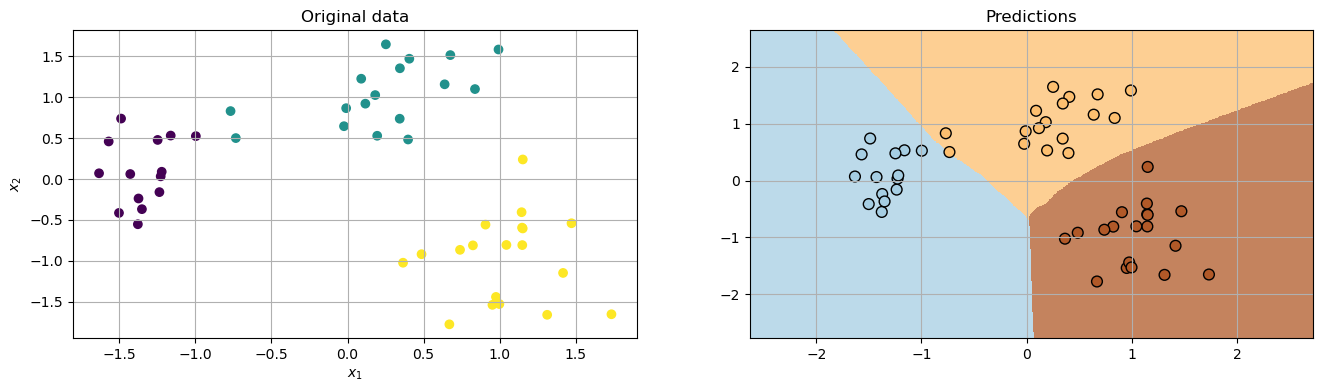

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))

ax[0].scatter(X_test[:, 0], X_test[:, 1], c=y_test)
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
ax[0].set_title('Original data')
ax[0].grid()

pp = np.argmax(mlp_from_saved(X_test).detach(), axis=1)
plot_decision_regions(X_test, pp, mlp_from_saved, ax=ax[1])

ax[1].set_title('Predictions')
ax[1].grid()

plt.show()